## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.regularizers import L1L2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
nltk.download(['stopwords', 'punkt'])
STOP_WORDS = set(stopwords.words('english'))

def categorize_rating(rating):
    if rating >= 7:
        return 'Positive'
    elif rating >= 4:
        return 'Neutral'
    else:
        return 'Negative'

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word not in STOP_WORDS]
    return ' '.join(filtered_text)

def load_and_preprocess_data(path):
    data = pd.read_csv(path)
    data.dropna(inplace=True)
    data['sentiment'] = data['rating'].apply(categorize_rating)
    data['cleaned_review'] = data['review'].apply(clean_text)
    return data

# Load and preprocess the data
train_data = load_and_preprocess_data('D:/Użytkownicy/Drozd Damian/drugsComTrain_raw.csv')
test_data = load_and_preprocess_data('D:/Użytkownicy/Drozd Damian/drugsComTest_raw.csv')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Damiś\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Damiś\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
test_data.head()
train_data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,cleaned_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,Positive,side effect take combination bystolic fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,Positive,son halfway fourth week intuniv became concern...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,Neutral,used take another oral contraceptive pill cycl...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,Positive,first time using form birth control glad went ...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,Positive,suboxone completely turned life around feel he...


In [46]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['cleaned_review'])
X = pad_sequences(tokenizer.texts_to_sequences(train_data['cleaned_review']), maxlen=100)
y = pd.get_dummies(train_data['sentiment']).values

In [47]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [48]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [49]:
# LSTM Model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=50, input_length=maxlen))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))


Epoch 1/20
1003/1003 [==============================] - 50s 48ms/step - loss: 0.6248 - accuracy: 0.7560 - val_loss: 0.5714 - val_accuracy: 0.7763
Epoch 2/20
1003/1003 [==============================] - 47s 47ms/step - loss: 0.5368 - accuracy: 0.7870 - val_loss: 0.5468 - val_accuracy: 0.7827
Epoch 3/20
1003/1003 [==============================] - 47s 46ms/step - loss: 0.4988 - accuracy: 0.8019 - val_loss: 0.5487 - val_accuracy: 0.7814
Epoch 4/20
1003/1003 [==============================] - 47s 46ms/step - loss: 0.4640 - accuracy: 0.8167 - val_loss: 0.5432 - val_accuracy: 0.7883
Epoch 5/20
1003/1003 [==============================] - 46s 46ms/step - loss: 0.4304 - accuracy: 0.8311 - val_loss: 0.5320 - val_accuracy: 0.7954
Epoch 6/20
1003/1003 [==============================] - 46s 46ms/step - loss: 0.3972 - accuracy: 0.8461 - val_loss: 0.5364 - val_accuracy: 0.7974
Epoch 7/20
1003/1003 [==============================] - 46s 46ms/step - loss: 0.3640 - accuracy: 0.8609 - val_loss: 0.5446 -

In [50]:
# CNN Model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=5000, output_dim=50, input_length=maxlen))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(3, activation='softmax'))
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn = model_cnn.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
1003/1003 [==============================] - 16s 15ms/step - loss: 0.6381 - accuracy: 0.7472 - val_loss: 0.5660 - val_accuracy: 0.7779
Epoch 2/20
1003/1003 [==============================] - 15s 15ms/step - loss: 0.5099 - accuracy: 0.8007 - val_loss: 0.5412 - val_accuracy: 0.7892
Epoch 3/20
1003/1003 [==============================] - 15s 15ms/step - loss: 0.4277 - accuracy: 0.8362 - val_loss: 0.5166 - val_accuracy: 0.8049
Epoch 4/20
1003/1003 [==============================] - 15s 15ms/step - loss: 0.3438 - accuracy: 0.8753 - val_loss: 0.5075 - val_accuracy: 0.8195
Epoch 5/20
1003/1003 [==============================] - 15s 15ms/step - loss: 0.2620 - accuracy: 0.9106 - val_loss: 0.5097 - val_accuracy: 0.8325
Epoch 6/20
1003/1003 [==============================] - 15s 15ms/step - loss: 0.1886 - accuracy: 0.9409 - val_loss: 0.5301 - val_accuracy: 0.8425
Epoch 7/20
1003/1003 [==============================] - 15s 15ms/step - loss: 0.1290 - accuracy: 0.9643 - val_loss: 0.5705 -

In [51]:
# Pre-Trained Word Embeddings (GloVe)
embeddings_index = {}
with open('D:/Użytkownicy/Drozd Damian/glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
embedding_matrix = np.zeros((5000, 100))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
model_pretrained = Sequential()
model_pretrained.add(Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model_pretrained.add(LSTM(64))
model_pretrained.add(Dense(3, activation='softmax'))
model_pretrained.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_pretrained = model_pretrained.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))


Epoch 1/20
1003/1003 [==============================] - 60s 58ms/step - loss: 0.7091 - accuracy: 0.7163 - val_loss: 0.6476 - val_accuracy: 0.7466
Epoch 2/20
1003/1003 [==============================] - 81s 81ms/step - loss: 0.6183 - accuracy: 0.7545 - val_loss: 0.6024 - val_accuracy: 0.7615
Epoch 3/20
1003/1003 [==============================] - 81s 81ms/step - loss: 0.5813 - accuracy: 0.7684 - val_loss: 0.5979 - val_accuracy: 0.7678
Epoch 4/20
1003/1003 [==============================] - 81s 81ms/step - loss: 0.5550 - accuracy: 0.7787 - val_loss: 0.5722 - val_accuracy: 0.7763
Epoch 5/20
1003/1003 [==============================] - 82s 81ms/step - loss: 0.5351 - accuracy: 0.7872 - val_loss: 0.5569 - val_accuracy: 0.7818
Epoch 6/20
1003/1003 [==============================] - 81s 81ms/step - loss: 0.5163 - accuracy: 0.7952 - val_loss: 0.5554 - val_accuracy: 0.7785
Epoch 7/20
1003/1003 [==============================] - 83s 82ms/step - loss: 0.5015 - accuracy: 0.8015 - val_loss: 0.5526 -

In [52]:
'''
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

def encode_reviews(tokenizer, reviews, max_length):
    return tokenizer(reviews, padding=True, truncation=True, max_length=max_length, return_tensors="tf")


max_length = 100  
encoded_train = encode_reviews(tokenizer, train_data['cleaned_review'].tolist(), max_length)
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(encoded_train),
    train_data['sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2}).values
)).batch(16)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

model.fit(train_dataset, epochs=3)

def predict_sentiment(model, reviews):
    encoded_reviews = encode_reviews(tokenizer, reviews, max_length)
    predictions = model.predict(encoded_reviews.data)['logits']
    sentiment = ['Negative', 'Neutral', 'Positive']
    for i, review in enumerate(reviews):
        print(f"Review: {review}")
        print(f"Predicted sentiment: {sentiment[tf.argmax(predictions[i]).numpy()]}\n")

sample_reviews = [
    "This medication was very effective and helped me recover quickly.",
    "I didn't notice any improvement while taking this medicine.",
    "After taking this drug I had severe headaches and felt worse than before."
]

print("Predictions:")
predict_sentiment(model, sample_reviews)
'''

'\nimport tensorflow as tf\nfrom transformers import AutoTokenizer, TFAutoModelForSequenceClassification\n\nmodel_name = "distilbert-base-uncased"\ntokenizer = AutoTokenizer.from_pretrained(model_name)\nmodel = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)\n\ndef encode_reviews(tokenizer, reviews, max_length):\n    return tokenizer(reviews, padding=True, truncation=True, max_length=max_length, return_tensors="tf")\n\n\nmax_length = 100  \nencoded_train = encode_reviews(tokenizer, train_data[\'cleaned_review\'].tolist(), max_length)\ntrain_dataset = tf.data.Dataset.from_tensor_slices((\n    dict(encoded_train),\n    train_data[\'sentiment\'].map({\'Negative\': 0, \'Neutral\': 1, \'Positive\': 2}).values\n)).batch(16)\n\nmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), \n              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), \n              metrics=[\'accuracy\'])\n\nmodel.fit(train_dataset, epochs=3)\n\nd

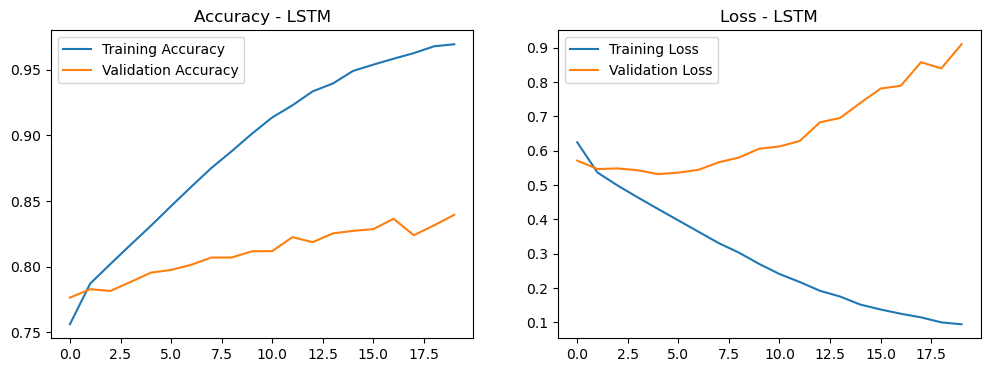

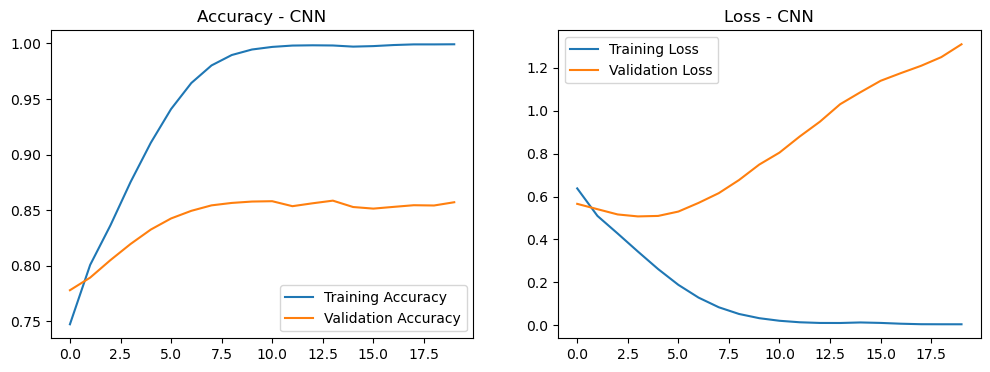

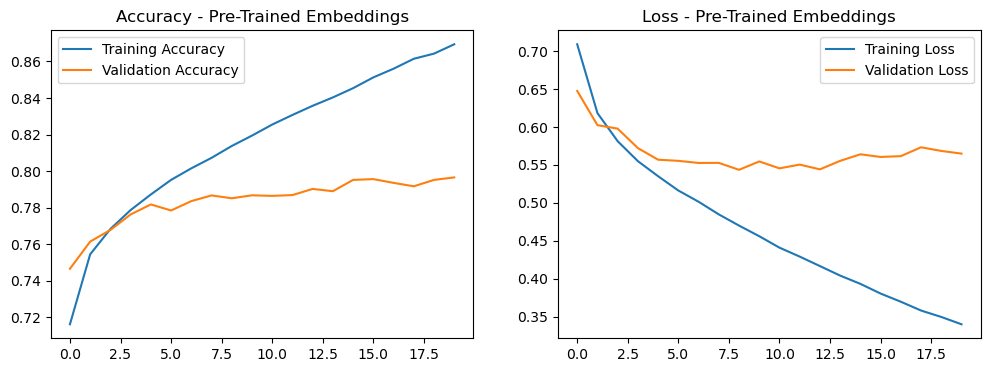

502/502 [==============================] - 5s 9ms/step


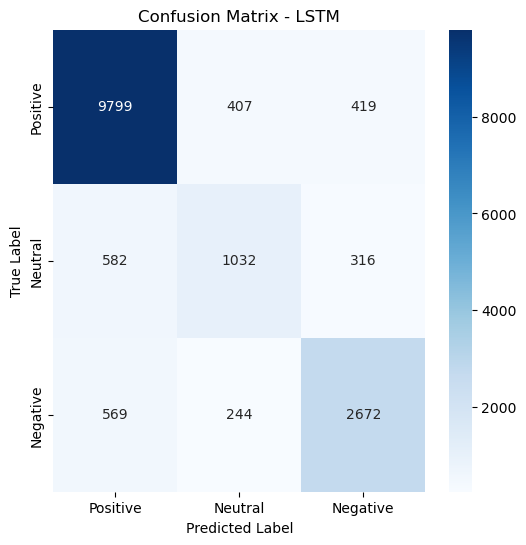

Classification Report for LSTM:
              precision    recall  f1-score   support

    Positive       0.89      0.92      0.91     10625
     Neutral       0.61      0.53      0.57      1930
    Negative       0.78      0.77      0.78      3485

    accuracy                           0.84     16040
   macro avg       0.76      0.74      0.75     16040
weighted avg       0.84      0.84      0.84     16040

502/502 [==============================] - 1s 2ms/step


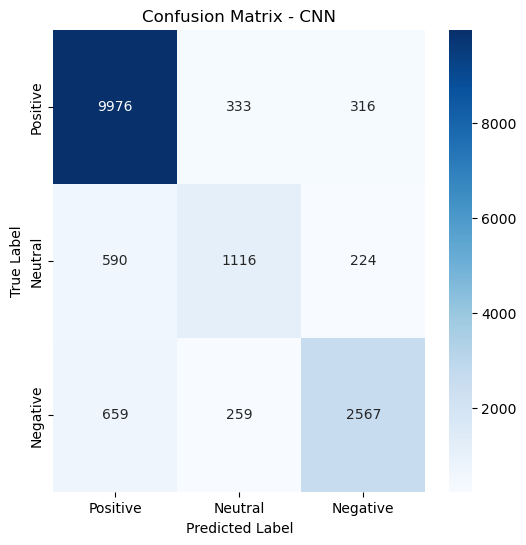

Classification Report for CNN:
              precision    recall  f1-score   support

    Positive       0.89      0.94      0.91     10625
     Neutral       0.65      0.58      0.61      1930
    Negative       0.83      0.74      0.78      3485

    accuracy                           0.85     16040
   macro avg       0.79      0.75      0.77     16040
weighted avg       0.85      0.85      0.85     16040

502/502 [==============================] - 6s 12ms/step


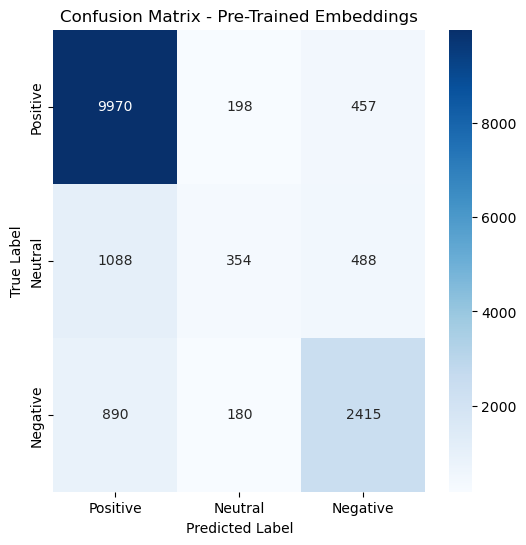

Classification Report for Pre-Trained Embeddings:
              precision    recall  f1-score   support

    Positive       0.83      0.94      0.88     10625
     Neutral       0.48      0.18      0.27      1930
    Negative       0.72      0.69      0.71      3485

    accuracy                           0.79     16040
   macro avg       0.68      0.60      0.62     16040
weighted avg       0.77      0.79      0.77     16040



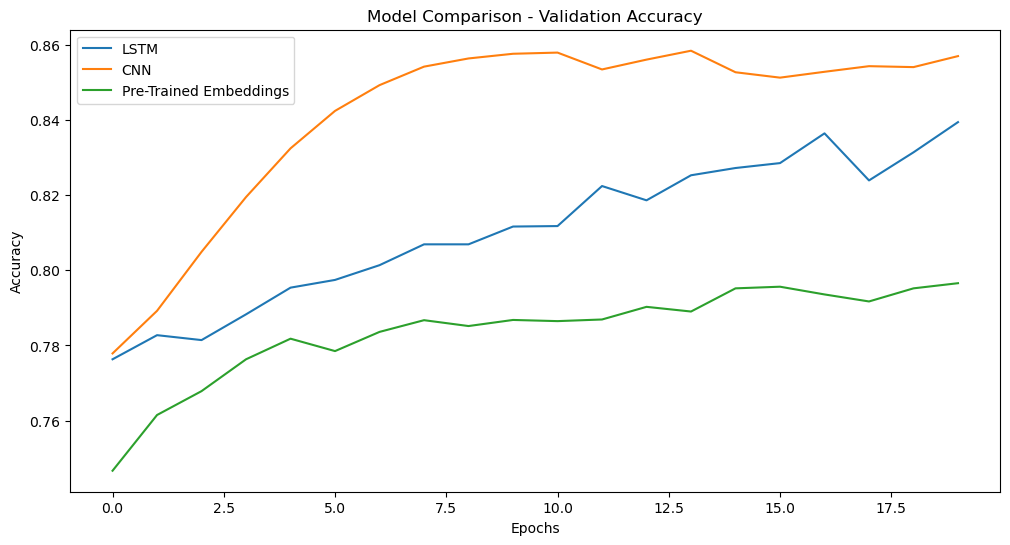

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def decode_sentiment(encoded_label):
    return 'Positive' if encoded_label[0] == 1 else ('Neutral' if encoded_label[1] == 1 else 'Negative')

def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy - ' + title)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss - ' + title)
    plt.legend()

    plt.show()


def plot_confusion_matrix(y_true, y_pred, title):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
    plt.title('Confusion Matrix - ' + title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


plot_history(history_lstm, 'LSTM')
plot_history(history_cnn, 'CNN')
plot_history(history_pretrained, 'Pre-Trained Embeddings')


for model, history, name in zip([model_lstm, model_cnn, model_pretrained], 
                                [history_lstm, history_cnn, history_pretrained], 
                                ['LSTM', 'CNN', 'Pre-Trained Embeddings']):

    y_pred = model.predict(X_test)
    y_pred_labels = [decode_sentiment(label) for label in y_pred.round()]
    y_true_labels = [decode_sentiment(label) for label in y_test]


    plot_confusion_matrix(y_true_labels, y_pred_labels, name)

    print(f"Classification Report for {name}:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=['Positive', 'Neutral', 'Negative']))

plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['val_accuracy'], label='LSTM')
plt.plot(history_cnn.history['val_accuracy'], label='CNN')
plt.plot(history_pretrained.history['val_accuracy'], label='Pre-Trained Embeddings')
plt.title('Model Comparison - Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [54]:

test_results_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
test_results_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)
test_results_pretrained = model_pretrained.evaluate(X_test, y_test, verbose=0)

print(f"LSTM Test Accuracy: {test_results_lstm[1]:.4f}")
print(f"CNN Test Accuracy: {test_results_cnn[1]:.4f}")
print(f"Pre-Trained Embeddings Test Accuracy: {test_results_pretrained[1]:.4f}")



LSTM Test Accuracy: 0.8419
CNN Test Accuracy: 0.8513
Pre-Trained Embeddings Test Accuracy: 0.7936


In [55]:
sample_reviews = [
    "This medication was very effective and helped me recover quickly.",  # Positive
    "The medication does work fast. However, I have weird mood",  # Neutral
    "After taking this drug I had severe headaches and felt worse than before."  # Negative
]

def predict_sentiment(model, reviews, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(reviews)
    data = pad_sequences(sequences, maxlen=max_length)
    predictions = model.predict(data)

    sentiment = ['Negative', 'Neutral', 'Positive']
    for i, review in enumerate(reviews):
        print(f"Review: {review}")
        print(f"Predicted sentiment: {sentiment[np.argmax(predictions[i])]}\n")

print("LSTM Predictions:")
predict_sentiment(model_lstm, sample_reviews, tokenizer, maxlen)

print("CNN Predictions:")
predict_sentiment(model_cnn, sample_reviews, tokenizer, maxlen)

print("Pre-Trained Embeddings Predictions:")
predict_sentiment(model_pretrained, sample_reviews, tokenizer, maxlen)


LSTM Predictions:
1/1 [==============================] - 0s 16ms/step
Review: This medication was very effective and helped me recover quickly.
Predicted sentiment: Positive

Review: The effects of the medication were neutral during the treatment period
Predicted sentiment: Negative

Review: After taking this drug I had severe headaches and felt worse than before.
Predicted sentiment: Negative

CNN Predictions:
1/1 [==============================] - 0s 13ms/step
Review: This medication was very effective and helped me recover quickly.
Predicted sentiment: Positive

Review: The effects of the medication were neutral during the treatment period
Predicted sentiment: Negative

Review: After taking this drug I had severe headaches and felt worse than before.
Predicted sentiment: Negative

Pre-Trained Embeddings Predictions:
1/1 [==============================] - 0s 17ms/step
Review: This medication was very effective and helped me recover quickly.
Predicted sentiment: Positive

Review: The 